In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

/local/.conda/envs/dl_sys/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import GPT2Model
model = GPT2Model.from_pretrained('gpt2')

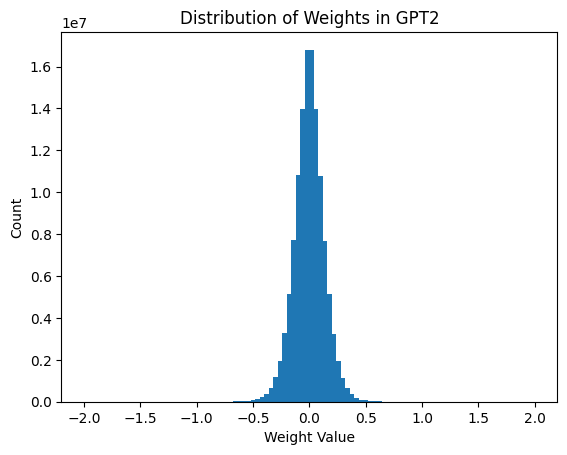

In [3]:
parameters = [p.flatten() for p in model.parameters() if p.requires_grad]
parameters = torch.cat(parameters)
hist = torch.histogram(parameters, range=(-2,2), bins=100)
bin_edges = hist.bin_edges.detach().numpy()
height = hist.hist.detach().numpy()
width = np.diff(bin_edges)
plt.title("Distribution of Weights in GPT2")
plt.bar(bin_edges[:-1], height, width=width, align='edge')
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.show()

Text(0.5, 0, 'Log Scale - Proportion of weights less than 2^x')

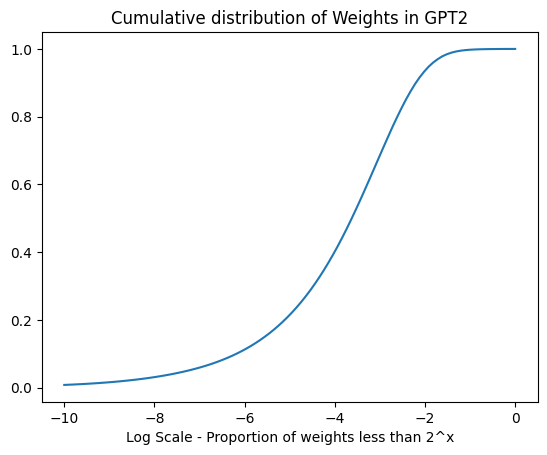

In [4]:
thresholds = np.linspace(0, -10, 100)
counts = np.zeros_like(thresholds)
for i in range(len(thresholds)):
    counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))
    
proportion = counts/parameters.shape[0]
plt.plot(thresholds, proportion)
plt.title("Cumulative distribution of Weights in GPT2")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")

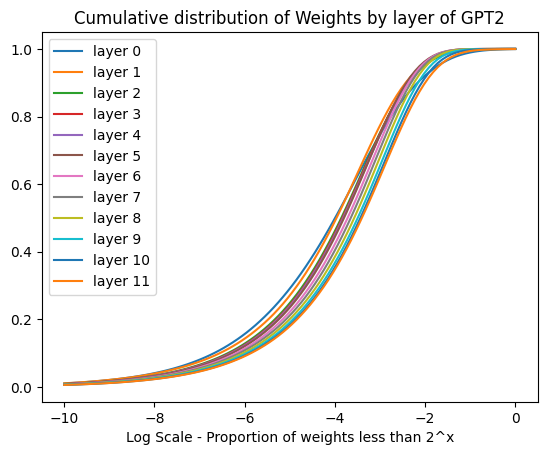

In [5]:
for j, layer in enumerate(model.h):
    thresholds = np.linspace(0, -10, 100)
    parameters = [p.flatten() for p in layer.parameters() if p.requires_grad]
    parameters = torch.cat(parameters)    
    counts = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))

    proportion = counts/parameters.shape[0]
    plt.plot(thresholds, proportion, label=f"layer {j}")
             
plt.title(f"Cumulative distribution of Weights by layer of GPT2")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.legend()
plt.show()

In [1]:
from transformers import T5Model
model = T5Model.from_pretrained("t5-large")

/local/.conda/envs/dl_sys/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.20k/1.20k [00:00<00:00, 809kB/s]
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.95G/2.95G [01:14<00:00, 39.6MB/s]


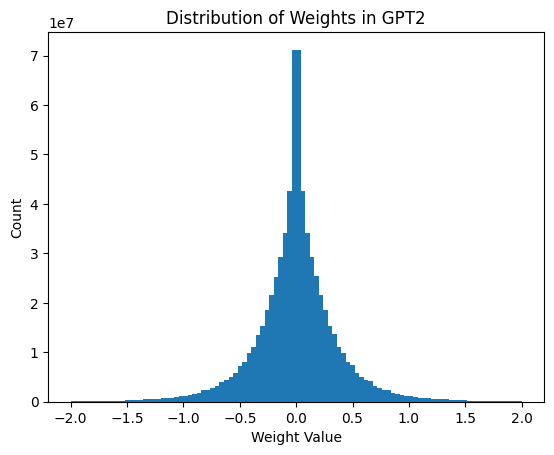

In [4]:
parameters = [p.flatten() for p in model.parameters() if p.requires_grad]
parameters = torch.cat(parameters)
hist = torch.histogram(parameters, range=(-2,2), bins=100)
bin_edges = hist.bin_edges.detach().numpy()
height = hist.hist.detach().numpy()
width = np.diff(bin_edges)
plt.title("Distribution of Weights in T5-Large")
plt.bar(bin_edges[:-1], height, width=width, align='edge')
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.show()

Text(0.5, 0, 'Log Scale - Proportion of weights less than 2^x')

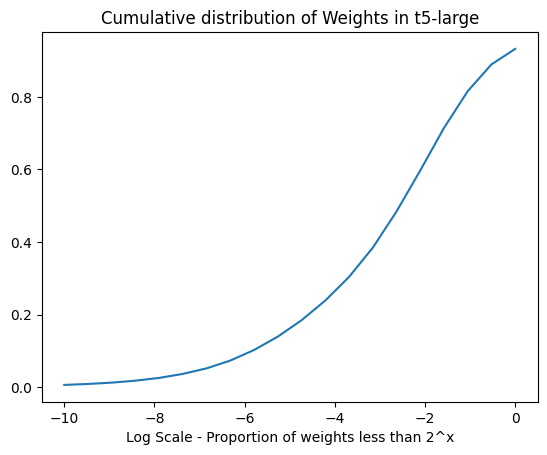

In [8]:
thresholds = np.linspace(0, -10, 20)
counts = np.zeros_like(thresholds)
for i in range(len(thresholds)):
    counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))
    
proportion = counts/parameters.shape[0]
plt.plot(thresholds, proportion)
plt.title("Cumulative distribution of Weights in t5-large")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")

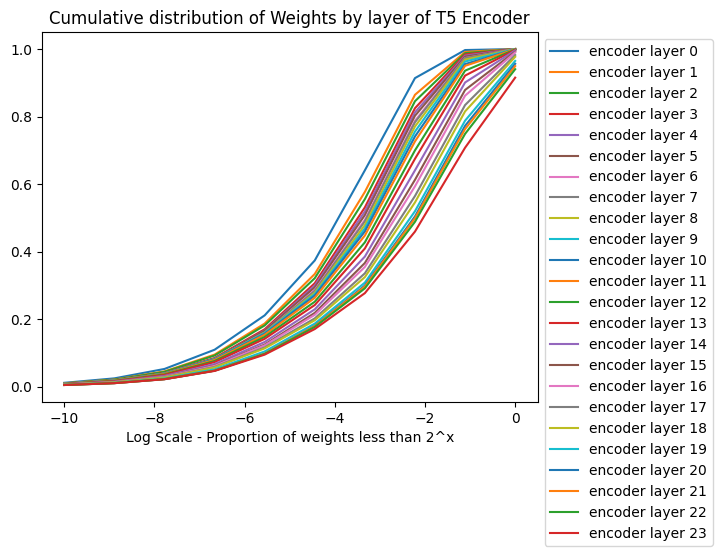

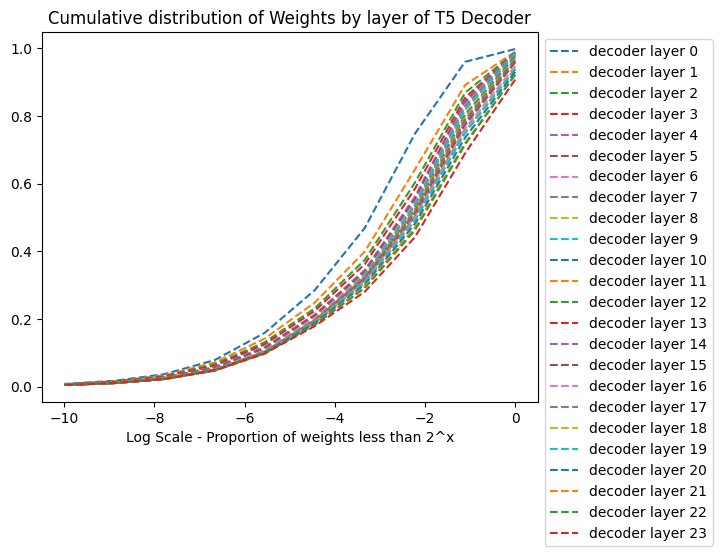

In [17]:
for j, layer in enumerate(model.encoder.block):
    thresholds = np.linspace(0, -10, 10)
    parameters = [p.flatten() for p in layer.parameters() if p.requires_grad]
    parameters = torch.cat(parameters)    
    counts = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))

    proportion = counts/parameters.shape[0]
    plt.plot(thresholds, proportion, label=f"encoder layer {j}")
    
plt.title(f"Cumulative distribution of Weights by layer of T5 Encoder")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()
    
for j, layer in enumerate(model.decoder.block):
    thresholds = np.linspace(0, -10, 10)
    parameters = [p.flatten() for p in layer.parameters() if p.requires_grad]
    parameters = torch.cat(parameters)    
    counts = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))

    proportion = counts/parameters.shape[0]
    plt.plot(thresholds, proportion, label=f"decoder layer {j}", linestyle="--")
             
plt.title(f"Cumulative distribution of Weights by layer of T5 Decoder")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [2]:
from transformers import DebertaV2Model
model = DebertaV2Model.from_pretrained('microsoft/deberta-v2-xxlarge')

Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


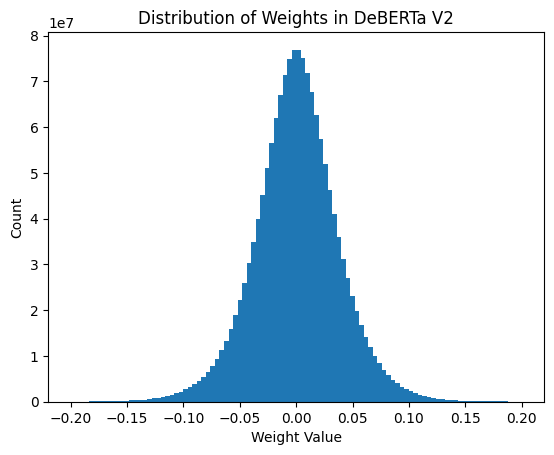

In [4]:
parameters = [p.flatten() for p in model.parameters() if p.requires_grad]
parameters = torch.cat(parameters)
hist = torch.histogram(parameters, range=(-0.2,.2), bins=100)
bin_edges = hist.bin_edges.detach().numpy()
height = hist.hist.detach().numpy()
width = np.diff(bin_edges)
plt.title("Distribution of Weights in DeBERTa V2")
plt.bar(bin_edges[:-1], height, width=width, align='edge')
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.show()

In [ ]:
thresholds = np.linspace(0, -10, 2)
counts = np.zeros_like(thresholds)
for i in range(len(thresholds)):
    counts[i] = torch.count_nonzero(torch.abs(parameters) < torch.power(2., thresholds[i]))
    
proportion = counts/parameters.shape[0]
plt.plot(thresholds, proportion)
plt.title("Cumulative distribution of Weights in DeBERTAv2")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")

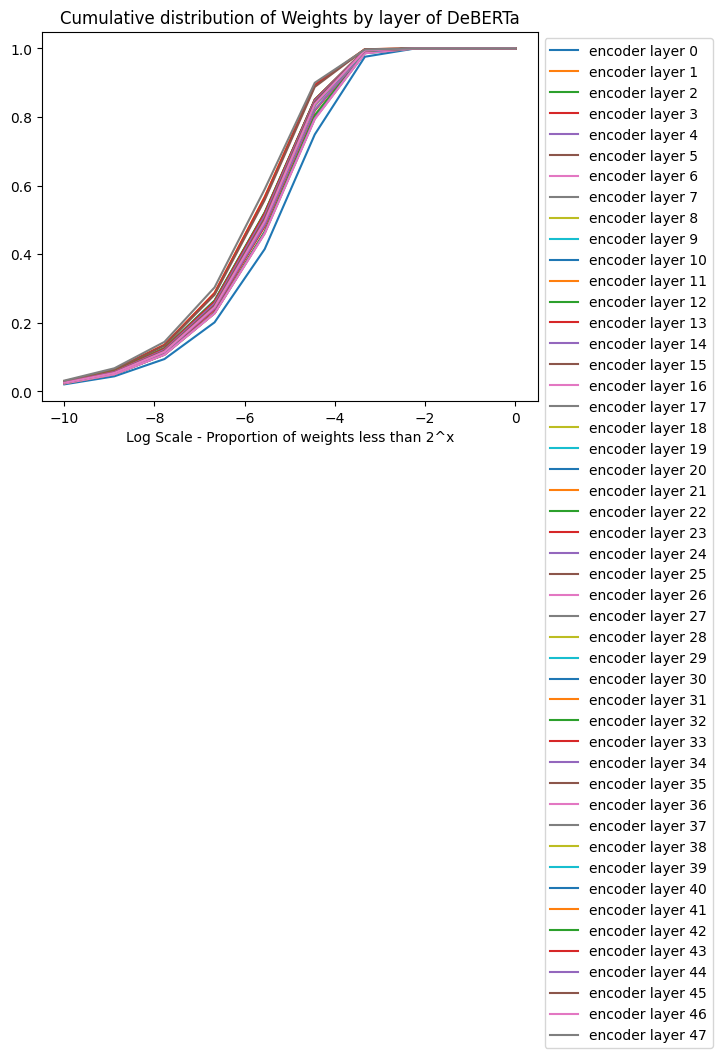

In [7]:
for j, layer in enumerate(model.encoder.layer):
    thresholds = np.linspace(0, -10, 10)
    parameters = [p.flatten() for p in layer.parameters() if p.requires_grad]
    parameters = torch.cat(parameters)    
    counts = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))

    proportion = counts/parameters.shape[0]
    plt.plot(thresholds, proportion, label=f"encoder layer {j}")
    
plt.title(f"Cumulative distribution of Weights by layer of DeBERTa")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()